
# Positional Encoding

In this lab, you will learn how to implement the positional encoding of words in the transformer.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

E0000 00:00:1743910841.936995  206122 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743910841.941326  206122 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Positional Encoding

In sequence to sequence tasks, the relative order of your data is extremely important to its meaning. When you were training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data was automatically fed into your model.  However, when you train a Transformer network using multi-head attention, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful - you can specifically encode the positions of your inputs and pass them into the network using these sine and cosine formulas:
    
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}$$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $k$ refers to each of the different dimensions in the positional encodings, with $i$ equal to $k$ $//$ $2$.

To develop some intuition about positional encodings, you can think of them broadly as a feature that contains the information about the relative positions of words. The sum of the positional encoding and word embedding is ultimately what is fed into the model. If you just hard code the positions in, say by adding a matrix of 1's or whole numbers to the word embedding, the semantic meaning is distorted. Conversely, the values of the sine and cosine equations are small enough (between -1 and 1) that when you add the positional encoding to a word embedding, the word embedding is not significantly distorted, and is instead enriched with positional information. Using a combination of these two equations helps your Transformer network attend to the relative positions of your input data.

### 1.1 - Sine and Cosine Angles

Notice that even though the sine and cosine positional encoding equations take in different arguments (`2i` versus `2i+1`, or even versus odd numbers) the inner terms for both equations are the same: $$\theta(pos, i, d) = \frac{pos}{10000^{\frac{2i}{d}}} \tag{3}$$

Consider the inner term as you calculate the positional encoding for a word in a sequence.<br> 
$PE_{(pos, 0)}= sin\left(\frac{pos}{{10000}^{\frac{0}{d}}}\right)$, since solving `2i = 0` gives `i = 0` <br>
$PE_{(pos, 1)}= cos\left(\frac{pos}{{10000}^{\frac{0}{d}}}\right)$, since solving `2i + 1 = 1` gives `i = 0`

The angle is the same for both! The angles for $PE_{(pos, 2)}$ and $PE_{(pos, 3)}$ are the same as well, since for both, `i = 1` and therefore the inner term is $\left(\frac{pos}{{10000}^{\frac{2}{d}}}\right)$. This relationship holds true for all paired sine and cosine curves:

|      k         | <code>       0      </code>|<code>       1      </code>|<code>       2      </code>|<code>       3      </code>| <code> ... </code> |<code>      d - 2     </code>|<code>      d - 1     </code>| 
| ---------------- | :------: | ----------------- | ----------------- | ----------------- | ----- | ----------------- | ----------------- |
| encoding(0) = |[$sin(\theta(0, 0, d))$| $cos(\theta(0, 0, d))$| $sin(\theta(0, 1, d))$| $cos(\theta(0, 1, d))$|... |$sin(\theta(0, d//2, d))$| $cos(\theta(0, d//2, d))$]|
| encoding(1) = | [$sin(\theta(1, 0, d))$| $cos(\theta(1, 0, d))$| $sin(\theta(1, 1, d))$| $cos(\theta(1, 1, d))$|... |$sin(\theta(1, d//2, d))$| $cos(\theta(1, d//2, d))$]|
...
| encoding(pos) = | [$sin(\theta(pos, 0, d))$| $cos(\theta(pos, 0, d))$| $sin(\theta(pos, 1, d))$| $cos(\theta(pos, 1, d))$|... |$sin(\theta(pos, d//2, d))$| $cos(\theta(pos, d//2, d))]$|

In [2]:
def get_angles(position, k, d_model):
    """
    Computes a positional encoding for a word 
    
    Arguments:
        position (int): position of the word
        k (int): refers to each of the different dimensions in the positional encodings, with i equal to k//2
        d_model(int): the dimension of the word embedding and positional encoding
    
    Returns:
        _ (float): positional embedding value for the word
    """
    i = k // 2
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    
    return position * angle_rates

### 1.2 - Sine and Cosine Positional Encodings

Now you can use the angles you computed to calculate the sine and cosine positional encodings, shown in equations (1) and (2).

In [3]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int): Maximum number of positions to be encoded 
        d (int): Encoding size 
    
    Returns:
        pos_encoding (tf.Tensor): A matrix of shape (1, position, d_model) with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[np.newaxis, :], d)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

Now you can visualize the positional encodings.

I0000 00:00:1743910844.007761  206122 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1759 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


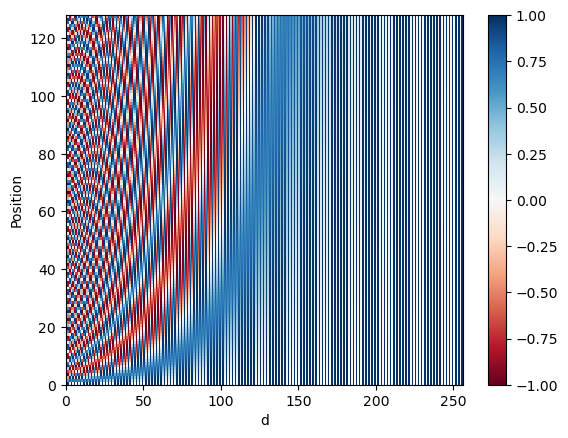

In [4]:
pos_encoding = positional_encoding(128, 256)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Each row represents a positional encoding - notice how none of the rows are identical! You have created a unique positional encoding for each of the words.

**Congratulations on finishing this Lab!** Now you should have a better understanding of the positional encoding in the transformer and this will surely help you with this week's assignment!

**Keep it up!**